# 05a Cell search for GI outcome



### Contents:
1. Set up and preparation for cell search  
1.1. Fit the top ensemble  
1.2. Find important features  
1.3. Determine most significant q values
2. Cell search  
3. Examining cell search results  
3.1. Coverage of quantile-based top subgroups by cell union  
3.2. Significance of selected cells  
3.3. Significance of selected cells w.r.t. TC outcome  
3.4. Similarity of selected cells
4. Results on test set  
4.1. Significance of selected cells  
4.2. Significance of selected cells w.r.t. TC outcome  
4.3. Significance of selected cells w.r.t. TC outcome, on TC-based split  
4.4. Significance of selected cells w.r.t. TC outcome, on all data

## 1. Set up and preparation for cell search

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import sys
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab

# Import own methods
from methods.data_processing import prepare_df, separate_vars
from methods.causal_functions import get_Neyman_ATE, get_Neyman_var
from methods.cate_estimator_wrappers import combine_estimator_versions
from methods.cate_estimator_validation import make_top_ensemble, get_top_subgroup_stability
from methods.cell_search import (get_feature_importance_scores, compare_q_values,
                                 CellSearch, get_cell_search_results,
                                 aggregate_cell_search_results, 
                                 get_coverage_results, get_cell_overlap_results, 
                                 get_cell_significance_results, get_RR_results)

Failed to import duecredit due to No module named 'duecredit'


In [2]:
# Load dataset configuration from 02 (features, treatment, outcomes)
from pathlib import Path
import pickle

outcome = "fausebal"
IMPUTATION_META = Path(f"output/params/{outcome}/analysis_imputation_meta.pkl")
if not IMPUTATION_META.exists():
    raise FileNotFoundError("Missing imputation metadata from 02. Run 02_tune_CATE_estimators.ipynb first.")
with open(IMPUTATION_META, 'rb') as f:
    _meta = pickle.load(f)

features = _meta["features"]
# Direction: infer from ATE on imputed dataset if needed later
n_splits = 4
q_values = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
dir_neg = True

# Paths for cached results
FILE_PATH = f"output/analysis/{outcome}/"
Path(FILE_PATH).mkdir(parents=True, exist_ok=True)

If notebook has already been run before, load cache of intermediate results using this cell.

In [3]:
# Load or build intermediate results aligned with current dataset
import os
from pathlib import Path

# Try to load fitted libraries from 03a/03b style cache
FITTED_LIBS_PATH = Path(FILE_PATH) / f"{outcome}_fitted_libraries.pkl"
TOP_NAMES_PATH = Path(FILE_PATH) / f"{outcome}_top_estimator_names.pkl"
TOP_ENSEMBLE_PATH = Path(FILE_PATH) / f"{outcome}_top_ensemble.pkl"
TOP_FEATURES_PATH = Path(FILE_PATH) / f"{outcome}_top_features.pkl"
CELL_SEARCH_PATH = Path(FILE_PATH) / f"{outcome}_cell_search_results.pkl"
PARAMS_PATH = Path(f'output/params/{outcome}') / f'{outcome}_tuned_params.pkl'

tuned_params = joblib.load(PARAMS_PATH)
fitted_libraries = joblib.load(FITTED_LIBS_PATH)
top_estimator_names = joblib.load(TOP_NAMES_PATH)

### 1.1. Fit the top ensemble

In [5]:
# Fit/load the top ensemble using current cache
# Fit the top ensemble
top_ensemble = make_top_ensemble(fitted_libraries, top_estimator_names)

In [6]:
print("Top ensemble estimators are:")
for idx, estimator_name in enumerate(top_estimator_names):
    print(idx + 1, estimator_name)

Top ensemble estimators are:
1 r_lassorf
2 r_rfxgb
3 t_logistic
4 causal_tree_1
5 t_rf
6 t_xgb
7 r_rfrf
8 causal_forest_2
9 causal_tree_2


### 1.2. Find significant quantile

In [7]:
compare_q_values(top_ensemble, [0.1, 0.2, 0.3, 0.4, 0.5]).round(2)

t-stat mean  t-stat std  overlap mean
0.1        -0.98        0.30          0.62
0.2        -0.90        0.27          0.62
0.3        -1.07        0.24          0.69
0.4        -1.05        0.19          0.76
0.5        -0.91        0.22          0.80

In [7]:
# Run this cell to generate latex code for table
#print(compare_q_values(top_ensemble, [0.1, 0.2, 0.3, 0.4, 0.5]).round(2).to_latex())

The 0.3, 0.4 q value gives by far the best $t$-statistic score, so we shall find important features and then cells that approximate it.  
We further check the stability of the quantile-based top subgroup of the ensemble w.r.t q = 0.1, by computing what percentage of  
its members are contained in the quantile-based top subgroup for other values of q, when the two subgroups are obtained from  
ensembles trained on different data splits.

In [8]:
q0 = 0.4
q_values_v2 = [0.1, 0.2, 0.3, 0.4, 0.5]
get_top_subgroup_stability(top_ensemble, q0, q_values_v2, dir_neg).round(2)

mean coverage  coverage std
0.1           0.24          0.01
0.2           0.44          0.02
0.3           0.62          0.03
0.4           0.76          0.04
0.5           0.85          0.04

### 1.3. Find important features

First we generate two different kinds of feature importance scores (refer to paper for details).  
We genereate these scores for each q in {0.1,0.2,0.3,0.4,0.5}.

In [9]:
mean_difference_df = get_feature_importance_scores(top_ensemble, "mean_difference", 
                                                   q_values, features, dir_neg).round(2)
mean_difference_df

0.5   0.4   0.3   0.2   0.1   max  mean
strat_2   -0.00 -0.00 -0.01 -0.01 -0.01  0.01  0.01
strat_3   -0.03 -0.05 -0.06 -0.06 -0.05  0.06  0.05
strat_4    0.02  0.02  0.01 -0.01 -0.03  0.03  0.02
strat_5    0.00  0.00  0.00  0.00  0.00  0.00  0.00
strat_6    0.00  0.00  0.00 -0.00 -0.00  0.00  0.00
...         ...   ...   ...   ...   ...   ...   ...
message    0.24  0.21  0.18  0.14  0.11  0.24  0.18
awareness  0.01  0.00  0.02  0.02  0.01  0.02  0.01
fa         0.04  0.02  0.01  0.01  0.01  0.04  0.02
billpayfa  0.07  0.06  0.05  0.04  0.03  0.07  0.05
debitfa    0.08  0.07  0.07  0.06  0.04  0.08  0.06

[321 rows x 7 columns]

In [10]:
log_coef_df = get_feature_importance_scores(top_ensemble, "log_coef", 
                                            q_values, features, dir_neg)
log_coef_df.round(2)

0.5   0.4   0.3   0.2   0.1   max  mean
strat_2   -0.01 -0.00 -0.01 -0.01 -0.01  0.01  0.01
strat_3   -0.01 -0.02 -0.02 -0.02 -0.02  0.02  0.02
strat_4    0.00  0.00 -0.00 -0.01 -0.02  0.02  0.01
strat_5    0.00  0.00  0.01  0.01  0.00  0.01  0.00
strat_6    0.00  0.00  0.00 -0.00 -0.01  0.01  0.00
...         ...   ...   ...   ...   ...   ...   ...
message    0.01  0.01  0.01  0.00  0.00  0.01  0.01
awareness  0.00  0.00  0.00  0.00  0.00  0.00  0.00
fa        -0.00 -0.00 -0.00 -0.00 -0.00  0.00  0.00
billpayfa  0.00  0.00  0.00  0.00  0.00  0.00  0.00
debitfa    0.00  0.00  0.00  0.00  0.00  0.00  0.00

[321 rows x 7 columns]

We rank the features by taking the mean over the scores for q=0.3 and q=0.4.

In [11]:
qs = [0.3, 0.4]
df2 = pd.DataFrame(log_coef_df[qs].mean(1), columns=["mean"])
df1 = pd.DataFrame(mean_difference_df[qs].mean(1), columns=["mean"])

q_pick = "mean"

df2[q_pick] = np.abs(df2[q_pick])
df2 = df2.sort_values(q_pick, ascending=False)

df1[q_pick] = np.abs(df1[q_pick])
df1 = df1.reindex(df2.index)

In [12]:
mean_difference_top = df1.sort_values(q_pick, ascending = False)[:8]
log_coef_top = df2.sort_values(q_pick, ascending = False)[:8]

top_features = np.unique(np.hstack((mean_difference_top.index, log_coef_top.index)))
print("Top features are:", top_features)
print("Num top features:", len(top_features))

Top features are: ['billpayfa' 'debitfa' 'message' 'strat_103' 'strat_24' 'strat_241'
 'strat_3' 'strat_47' 'strat_62' 'strat_63' 'strat_66' 'strat_8'
 'strat_83' 'strat_86']
Num top features: 14


Let's now plot the scores.

In [13]:
# Plot style settings
plt.style.use("fivethirtyeight")
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

SAVE_PATH  = f"output/figures/{outcome}/"

In [14]:
imp_type =  ["Logistic"]*8
imp_type += ["Difference"]*8

In [15]:
d = {'values': np.hstack((mean_difference_top.values.T[0]/sum(mean_difference_top.values), 
                          log_coef_top.values.T[0]/sum(log_coef_top.values))),
     "feature" : np.hstack((mean_difference_top.index, log_coef_top.index)),
     'type': imp_type}
#joblib.dump(d, "data_files/GI/GI_feat_imp")

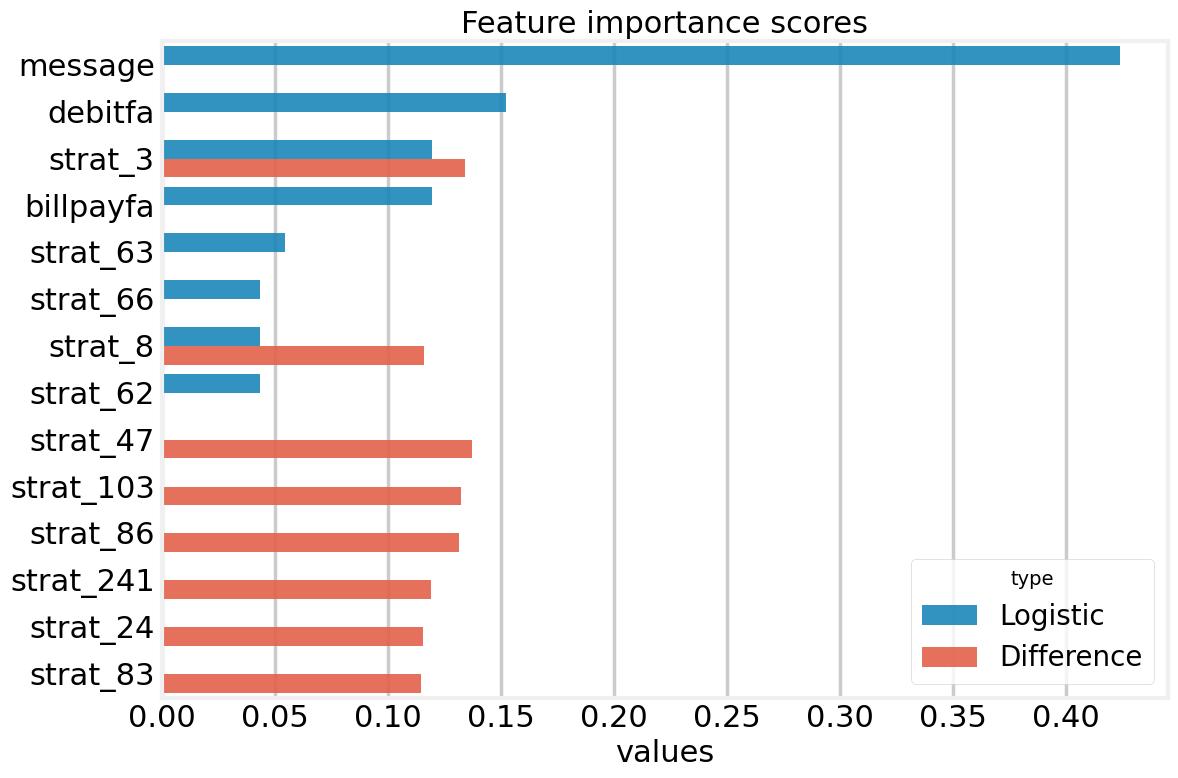

In [16]:
savfig = False
temp_df = pd.DataFrame(d)
fig, ax = plt.subplots(figsize=[12, 8])
sns.barplot(y='feature', x='values', hue='type', data=temp_df,  orient='h', ax=ax, alpha=0.9)
ax.set_ylabel('')
plt.title("Feature importance scores")
plt.tight_layout()
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome}_feat_imp.pdf")
plt.show()

## 2. Cell search

A description of the cell search algorithm can be found in the paper.

In this section, we perform multiple runs of cell search, by varying the training fold used to train  
the estimator. Furthermore, in cell search, there is an option to randomize the algorithm by choosing  
randomly from among a list of top cells. In the multiple runs, we also vary the random seed used to do  
this.

In [17]:
# Options for cell search
outcome = "fausebal"
q_values = [0.3, 0.4]
n_cells = 3
max_features = 3
n_reps = 5
penalty = 1
tol = 0.1
min_support = 0.001
# dir_neg already set from setup
trainval_df = pd.read_csv(f"output/analysis/{outcome}/trainval_data.csv")

In [20]:
# Run cell search
search_results_df = get_cell_search_results(top_ensemble, features, top_features, 
                            q_values, n_cells, max_features, n_reps, penalty, 
                            tol, min_support, dir_neg)

  0%|          | 0/12 [24:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
joblib.dump(search_results_df, Path(FILE_PATH) / f"{outcome}_cell_search_results.joblib")

['data_files/GI/GI_cell_search_results']

In [20]:
aggregated_results_df = aggregate_cell_search_results(search_results_df, trainval_df[features], 
                                                      collapse_cells = True).round(2)
aggregated_results_df[:20]

NameError: name 'trainval_df' is not defined

Here, we have aggregated the cell search results, with the `collapse_cells` flag set to `True`.  
This means that to the count of each cell, we also add the count of sub-cells that occur, weighted  
by their size (in terms of number of samples) relative to that of the super-cell.

In [14]:
# aggregated_results_df = aggregate_cell_search_results(search_results_df, trainval_df, 
#                                                       collapse_cells = False).round(2)
# aggregated_results_df

We now simplify this table for display in the paper. We rank the cells according to their "mean",  
i.e. the mean of the frequency with which they were selected for each q value.

In [21]:
agg_results = aggregated_results_df[["q=%.1f"%q for q in q_values] + ["total frequency"]] \
                                .rename(columns={"total frequency":"mean"})[:20]
for q in q_values:
    agg_results["q=%.1f"%q] /= aggregated_results_df["num runs"]

for column in agg_results.keys():
    agg_results[column] *= 100
agg_results = agg_results.round(0).astype(int)
agg_results

NameError: name 'aggregated_results_df' is not defined

In [22]:
top_cells = list(agg_results.index[:3])

NameError: name 'agg_results' is not defined

We manually format this table for the paper.

In [16]:
#agg_table = agg_results.to_latex()

In [31]:
# format_table = ''
# j = 0
# while(j<len(agg_table)):
#     s = agg_table[j]
#     if s == '(':
#         format_table += "\{"
#         j+=1
#     elif s== ')':
#         format_table += "\}"
#         j+=1
#     elif agg_table[j:j+5] == 'white':
#         format_table += "WHITE"
#         j+=5
#     elif agg_table[j:j+6] == 'smoker':
#         format_table += "SMOKE"
#         j+=6
#     elif agg_table[j:j+16] == "elderly\_65\_adj":
#         format_table += "ELDERLY"
#         j+=16
#     elif agg_table[j:j+19] =='PUB\_PRIOR\_HISTORY':
#         format_table += "PPH"
#         j+=19
#     elif agg_table[j:j+7] =='drinker':
#         format_table += "DRINK"
#         j+=7
#     elif agg_table[j:j+10] =='overweight':
#         format_table += "OVERWEIGHT"
#         j+=10
#     elif agg_table[j:j+5] =='obese':
#         format_table += "OBESE"
#         j+=5
#     elif agg_table[j:j+4] =='male':
#         format_table += "MALE"
#         j+=4
#     elif agg_table[j:j+3] =='\_1':
#         format_table += "=1"
#         j+=3
#     elif agg_table[j:j+3] =='\_0':
#         format_table += "=0"
#         j+=3
#     else:
#         format_table += s
#         j+=1
# print(format_table)

## 3. Examining cell search results

In [23]:
print("The cells selected are: ")
for idx, cell in enumerate(top_cells):
    print(f"{idx+1}.", cell)

The cells selected are: 


NameError: name 'top_cells' is not defined

### 3.1. Coverage of quantile-based top subgroups by cell union

This first table shows the coverage statistics of the cells selected with respect to various q values.

In [24]:
coverage_results_df = get_coverage_results(top_cells, trainval_df, top_ensemble, 
                                           [0.1, 0.2, 0.3, 0.4, 0.5], dir_neg)
coverage_results_df.round(2)

NameError: name 'top_cells' is not defined

### 3.2. Significance of selected cells

The next two tables display the CATE, $t$-statistic and relative risk of the selected cells as well as their union.

In [25]:
# Use the imputed trainval_df aligned with 02
trainval_df = trainval_df.copy()

NameError: name 'trainval_df' is not defined

In [26]:
sig_cate = get_cell_significance_results(top_cells, trainval_df[outcome_name].values, 
                                         trainval_df["TREATED"].values, trainval_df[features], 
                                         top_ensemble)
sig_cate.round(3)

NameError: name 'top_cells' is not defined

In [27]:
get_RR_results(top_cells, trainval_df[outcome_name].values, trainval_df["TREATED"].values, trainval_df[features]).round(2)

NameError: name 'top_cells' is not defined

### 3.3. Significance of selected cells w.r.t. cardiovascular outcome

In [28]:
# Legacy cross-outcome section disabled for current dataset
raise SystemExit("Skip cross-outcome significance: not applicable for current dataset setup.")

SystemExit: Skip cross-outcome significance: not applicable for current dataset setup.

d:\statistics\jofe\causal-targeting-main\venv\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [29]:
cross_cate_train = get_cell_significance_results(top_cells, 
                    cfd_cardio, top_ensemble.t, trainval_df, top_ensemble).round(3)
cross_cate_train

NameError: name 'top_cells' is not defined

In [30]:
get_RR_results(top_cells, cfd_cardio, top_ensemble.t, trainval_df).round(2)

NameError: name 'top_cells' is not defined

### 3.4. Similarity of selected cells

The following two heat maps show how similar the selected cells are to each other, in terms of intersection size and cosine similarity.

In [31]:
# Plot style settings
plt.style.use("fivethirtyeight")
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
SAVE_PATH  = f"figs/{outcome_name}/"

In [32]:
savfig = False
intersection_mat = get_cell_overlap_results(top_cells, trainval_df, 
                                            "intersection_size")
joblib.dump(intersection_mat, FILE_PATH + f"{outcome_name}_cell_overlap_mat")
c = intersection_mat.shape[0]
plt.figure(figsize=[8, 6])
sns.heatmap(intersection_mat, annot = True, fmt = "d", 
            cmap = sns.color_palette("Blues"), annot_kws={'size':20},
            vmin = 0, vmax = intersection_mat.values.max())
cell_ticks = [r'$\mathbb{C}_{%d}$'%(j+1) for j in range(c)]
plt.xticks(np.arange(3)+0.5, cell_ticks)
plt.yticks(np.arange(3)+0.5, cell_ticks, rotation=0)
plt.title(f"{outcome_name} cells overlap matrix")
plt.tight_layout()

if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_cell_heatmap.pdf")
plt.show()

NameError: name 'top_cells' is not defined

In [33]:
cosine_sim_mat = get_cell_overlap_results(top_cells, trainval_df, "cosine_sim")
plt.figure()
sns.heatmap(cosine_sim_mat, annot = True, cmap = sns.color_palette("Blues"),
            annot_kws={'size':20}, vmin = 0, vmax = 1)
plt.show()

NameError: name 'top_cells' is not defined

# 4. Results on test Set 

### 4.1. Significance of selected cells (Train only for current dataset)

In [ ]:
# Use the imputed trainval_df only; no separate external test split available
# Keeping trainval_df from setup cell

In [34]:
print("Train")
sig_cate.round(3)

Train


NameError: name 'sig_cate' is not defined

In [35]:
print("Test")
print("Skipping: no separate test split in current dataset")
test_cate = None

Test
Skipping: no separate test split in current dataset


Let's combine both tables together.

In [36]:
# Join only if test_cate is available
if test_cate is not None:
    cate_join = sig_cate.join(test_cate, how='outer', lsuffix="_train", rsuffix="_test")
    cols = ['num_evts_train', 'size_train', 'num_evts_test', 'size_test', 
            'CATE_train', 'CATE_std_train', 'CATE_test', 'CATE_std_test', 
            't-stat (overall)_train', 't-stat (overall)_test', 
            't-stat (val) mean', 't-stat (val) std']
    cate_join[cols].round(3)
else:
    sig_cate.round(3)

NameError: name 'sig_cate' is not defined

For reference, we generate the ATE over train and test sets.

In [37]:
ATE_df = pd.DataFrame(columns = ["size", "num events", "ATE", "ATE std"])
size = trainval_df.shape[0]
num_events = trainval_df[outcome_name].sum()
ATE = get_Neyman_ATE(trainval_df[outcome_name], trainval_df["TREATED"])
ATE_std = np.sqrt(get_Neyman_var(trainval_df[outcome_name], trainval_df["TREATED"]))
ATE_df = ATE_df.append(pd.Series({"size" : size, "num events" : num_events, 
                                  "ATE" : ATE, "ATE std" : ATE_std}, 
                                 name = "train"))

NameError: name 'trainval_df' is not defined

In [62]:
ATE_df.round(3)

size  num events    ATE  ATE std
train  6460.0       142.0 -0.016    0.004
test   1616.0        35.0 -0.016    0.007

### 4.2. Significance of selected cells w.r.t. TC outcome  

In [ ]:
# Skipped: cross outcome on train/test split not present in current dataset
raise SystemExit("Skip cross-outcome test split section.")

In [44]:
print(f"train {cross_outcome} on {outcome_name} split")
cross_cate_train

train cfd_cardio on GI split


size  num_evts   CATE  CATE_std  \
PUB_PRIOR_HISTORY==1            501         2 -0.008     0.006   
PSTRDS==1 & HYPGRP==1          1008        11  0.010     0.007   
PSTRDS==1 & elderly_65_adj==1   894        14  0.019     0.008   
union                          1905        19  0.009     0.005   

                               t-stat (overall)  t-stat (val) mean  \
PUB_PRIOR_HISTORY==1                     -2.724             -1.677   
PSTRDS==1 & HYPGRP==1                     0.410              0.136   
PSTRDS==1 & elderly_65_adj==1             1.495              0.549   
union                                     0.481              0.149   

                               t-stat (val) std  
PUB_PRIOR_HISTORY==1                      0.216  
PSTRDS==1 & HYPGRP==1                     0.239  
PSTRDS==1 & elderly_65_adj==1             0.327  
union                                     0.278

In [45]:
print(f"test {cross_outcome} on {outcome_name} split")
cross_test_cate = get_cell_significance_results(top_cells, 
                cross_test_df[cross_outcome], cross_test_df["TREATED"], 
                cross_test_df[features], on_trainval = False)
cross_test_cate.round(3)

test cfd_cardio on GI split


size  num_evts  CATE  CATE_std  \
PUB_PRIOR_HISTORY==1            129         0   0.0     0.000   
PSTRDS==1 & HYPGRP==1           238         0   0.0     0.000   
PSTRDS==1 & elderly_65_adj==1   227         2  -0.0     0.012   
union                           471         2   0.0     0.006   

                               t-stat (overall)  
PUB_PRIOR_HISTORY==1                      0.385  
PSTRDS==1 & HYPGRP==1                     0.385  
PSTRDS==1 & elderly_65_adj==1             0.093  
union                                     0.252

Let's combine both tables together.

In [122]:
cross_join = cross_cate_train.join(cross_test_cate,
                        how='outer', lsuffix="_train", rsuffix="_test")

cross_join[['num_evts_train', 'size_train', 'num_evts_test', 'size_test', 
            'CATE_train', 'CATE_std_train', 'CATE_test', 'CATE_std_test', 
            't-stat (overall)_train', 't-stat (overall)_test', "t-stat (val) mean", 
            "t-stat (val) std"]].round(3)

num_evts_train  size_train  num_evts_test  \
PUB_PRIOR_HISTORY==1                        2         501              0   
PSTRDS==1 & HYPGRP==1                      11        1008              0   
PSTRDS==1 & elderly_65_adj==1              14         894              2   
union                                      19        1905              2   

                               size_test  CATE_train  CATE_std_train  \
PUB_PRIOR_HISTORY==1                 129      -0.008           0.006   
PSTRDS==1 & HYPGRP==1                238       0.010           0.007   
PSTRDS==1 & elderly_65_adj==1        227       0.019           0.008   
union                                471       0.009           0.005   

                               CATE_test  CATE_std_test  \
PUB_PRIOR_HISTORY==1                 0.0          0.000   
PSTRDS==1 & HYPGRP==1                0.0          0.000   
PSTRDS==1 & elderly_65_adj==1       -0.0          0.012   
union                                0.0          0.006   

                               t-stat (overall)_train  t-stat (overall)_test  \
PUB_PRIOR_HISTORY==1                           -2.724                  0.385   
PSTRDS==1 & HYPGRP==1                           0.410                  0.385   
PSTRDS==1 & elderly_65_adj==1                   1.495                  0.093   
union                                           0.481                  0.252   

                               t-stat (val) mean  t-stat (val) std  
PUB_PRIOR_HISTORY==1                      -1.677             0.216  
PSTRDS==1 & HYPGRP==1                      0.136             0.239  
PSTRDS==1 & elderly_65_adj==1              0.549             0.327  
union                                      0.149             0.278

For reference, we generate the ATE over train and test sets.

In [68]:
ATE_df = pd.DataFrame(columns = ["size", "num events", "ATE", "ATE std"])
for name, df in zip(["train", "test"], [cross_train_df, cross_test_df]):
    size = df.shape[0]
    num_events = df[cross_outcome].sum()
    ATE = get_Neyman_ATE(df[cross_outcome], df["TREATED"])
    ATE_std = np.sqrt(get_Neyman_var(df[cross_outcome], df["TREATED"]))
    ATE_df = ATE_df.append(pd.Series({"size" : size, "num events" : num_events, 
                                      "ATE" : ATE, "ATE std" : ATE_std}, 
                                     name = name))

In [69]:
ATE_df.round(3)

size  num events    ATE  ATE std
train  6460.0        52.0  0.007    0.002
test   1616.0         7.0 -0.001    0.003

### 4.3. Significance of selected cells w.r.t. TC outcome, on TC-based split

In [ ]:
# Skipped: cross-outcome significance on TC-based split
raise SystemExit("Skip cross-outcome on TC-based split.")

In [71]:
print(f"train {cross_outcome} on {cross_outcome} split")
new_cross_train_cate = get_cell_significance_results(top_cells, 
                        new_cross_train_df[cross_outcome], new_cross_train_df["TREATED"], 
                            new_cross_train_df[features], on_trainval = False)
new_cross_train_cate.round(3)

train cfd_cardio on cfd_cardio split


size  num_evts   CATE  CATE_std  \
PUB_PRIOR_HISTORY==1            506         1 -0.004     0.004   
PSTRDS==1 & HYPGRP==1           976         8  0.008     0.006   
PSTRDS==1 & elderly_65_adj==1   887        12  0.013     0.008   
union                          1879        15  0.007     0.004   

                               t-stat (overall)  
PUB_PRIOR_HISTORY==1                     -2.338  
PSTRDS==1 & HYPGRP==1                     0.369  
PSTRDS==1 & elderly_65_adj==1             1.104  
union                                     0.375

In [72]:
print(f"test {cross_outcome} on {cross_outcome} split")
new_cross_test_cate = get_cell_significance_results(top_cells, 
                                new_cross_test_df[cross_outcome], 
                    new_cross_test_df["TREATED"], new_cross_test_df[features], 
                                                    on_trainval = False)
new_cross_test_cate.round(3)

test cfd_cardio on cfd_cardio split


size  num_evts   CATE  CATE_std  \
PUB_PRIOR_HISTORY==1            124         1 -0.016     0.016   
PSTRDS==1 & HYPGRP==1           270         3  0.008     0.013   
PSTRDS==1 & elderly_65_adj==1   234         4  0.020     0.018   
union                           497         6  0.009     0.010   

                               t-stat (overall)  
PUB_PRIOR_HISTORY==1                     -1.369  
PSTRDS==1 & HYPGRP==1                     0.261  
PSTRDS==1 & elderly_65_adj==1             0.950  
union                                     0.499

Let's combine both tables together.

In [77]:
new_cross_join = new_cross_train_cate.join(new_cross_test_cate,
                        how='outer', lsuffix="_train", rsuffix="_test")

print(f"Cross: {cross_outcome} on {cross_outcome} split")
new_cross_join[['num_evts_train', 'size_train', 'num_evts_test', 'size_test', 
                'CATE_train', 'CATE_std_train', 'CATE_test', 'CATE_std_test', 
                't-stat (overall)_train', 't-stat (overall)_test']].round(3)

Cross: cfd_cardio on cfd_cardio split


num_evts_train  size_train  num_evts_test  \
PUB_PRIOR_HISTORY==1                        1         506              1   
PSTRDS==1 & HYPGRP==1                       8         976              3   
PSTRDS==1 & elderly_65_adj==1              12         887              4   
union                                      15        1879              6   

                               size_test  CATE_train  CATE_std_train  \
PUB_PRIOR_HISTORY==1                 124      -0.004           0.004   
PSTRDS==1 & HYPGRP==1                270       0.008           0.006   
PSTRDS==1 & elderly_65_adj==1        234       0.013           0.008   
union                                497       0.007           0.004   

                               CATE_test  CATE_std_test  \
PUB_PRIOR_HISTORY==1              -0.016          0.016   
PSTRDS==1 & HYPGRP==1              0.008          0.013   
PSTRDS==1 & elderly_65_adj==1      0.020          0.018   
union                              0.009          0.010   

                               t-stat (overall)_train  t-stat (overall)_test  
PUB_PRIOR_HISTORY==1                           -2.338                 -1.369  
PSTRDS==1 & HYPGRP==1                           0.369                  0.261  
PSTRDS==1 & elderly_65_adj==1                   1.104                  0.950  
union                                           0.375                  0.499

For reference, we generate the ATE over train and test sets.

In [75]:
ATE_df = pd.DataFrame(columns = ["size", "num events", "ATE", "ATE std"])
for name, df in zip(["train", "test"], [new_cross_train_df, new_cross_test_df]):
    size = df.shape[0]
    num_events = df[cross_outcome].sum()
    ATE = get_Neyman_ATE(df[cross_outcome], df["TREATED"])
    ATE_std = np.sqrt(get_Neyman_var(df[cross_outcome], df["TREATED"]))
    ATE_df = ATE_df.append(pd.Series({"size" : size, "num events" : num_events, 
                                      "ATE" : ATE, "ATE std" : ATE_std}, 
                                     name = name))

In [76]:
ATE_df.round(3)

size  num events    ATE  ATE std
train  6460.0        47.0  0.006    0.002
test   1616.0        12.0  0.005    0.004

### 4.4. Significance of selected cells w.r.t. TC outcome, on all data

In [ ]:
# Skipped: all-data cross-outcome analysis
raise SystemExit("Skip all-data cross-outcome analysis.")

In [88]:
print(f"{cross_outcome} on all data")
all_cross_cate = get_cell_significance_results(top_cells, 
                all_df[cross_outcome], all_df["TREATED"], 
                all_df[features], on_trainval = False)
all_cross_cate.round(3)

cfd_cardio on all data


size  num_evts   CATE  CATE_std  \
PUB_PRIOR_HISTORY==1            630         2 -0.006     0.004   
PSTRDS==1 & HYPGRP==1          1246        11  0.008     0.005   
PSTRDS==1 & elderly_65_adj==1  1121        16  0.015     0.007   
union                          2376        21  0.007     0.004   

                               t-stat (overall)  
PUB_PRIOR_HISTORY==1                     -2.657  
PSTRDS==1 & HYPGRP==1                     0.437  
PSTRDS==1 & elderly_65_adj==1             1.422  
union                                     0.552

In [92]:
ATE = get_Neyman_ATE(all_df[cross_outcome], all_df["TREATED"])
ATE_std = np.sqrt(get_Neyman_var(all_df[cross_outcome], all_df["TREATED"]))
print(f"The ATE for TC on all the data is: {ATE:.3f} ({ATE_std:.3f})")
print("The total number of events is:", all_df[cross_outcome].sum())

The ATE for TC on all the data is: 0.006 (0.002)
The total number of events is: 59
